# Planet Isochrones - Mass Group Project 3
## Author:  Jason Wang (Northwestern University/CIERA)

Run the [SSW2024_PSF_Setup_Subtraction](https://colab.research.google.com/drive/1AmrmAj459MwUt4kkUbfquxnf1GkyO_F2?usp=share_link) notebook to download the data.  The setup notebook needs to just be run **once** once for Hands-on Session IV.

We will convert the flux ratio we measured for a planet into mass.

See the Group Project Idea 3 at the end of [SSW2024_ImagingExoplanets.ipynb](https://colab.research.google.com/drive/1XVUe9-qYAQs_9VVszxuw8Mih49dnhZjX?usp=sharing).

## PROJECT

# Libraries

In [16]:
import os
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.io.fits as fits
import scipy.ndimage
import pyklip.klip
import pyklip.parallelized
import pyklip.instruments.Instrument as Instrument
import pyklip.fakes
import pyklip.kpp.metrics.crossCorr
import pyklip.kpp.stat.statPerPix_utils
import species
from species.data.database import Database
from species.read.read_isochrone import ReadIsochrone

%matplotlib inline

species.SpeciesInit()

/home/visage/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


species v0.8.4

Working folder: /home/visage/Documents/github/PSF_Substraction

Configuration file: /home/visage/Documents/github/PSF_Substraction/species_config.ini
Database file: /home/visage/Documents/github/PSF_Substraction/species_database.hdf5
Data folder: /home/visage/Documents/github/PSF_Substraction/data

Configuration settings:
   - Database: /home/visage/Documents/github/PSF_Substraction/species_database.hdf5
   - Data folder: /home/visage/Documents/github/PSF_Substraction/data
   - Magnitude of Vega: 0.03

Multiprocessing: mpi4py installed
Process number 1 out of 1...


# Getting the image for DS9 (everything is copied from the notebooks)

Text(0.5, 1.0, 'Calibration Frame')

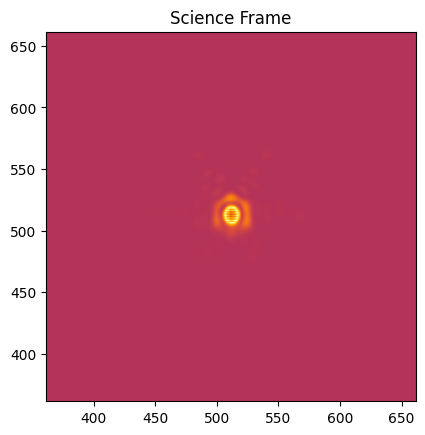

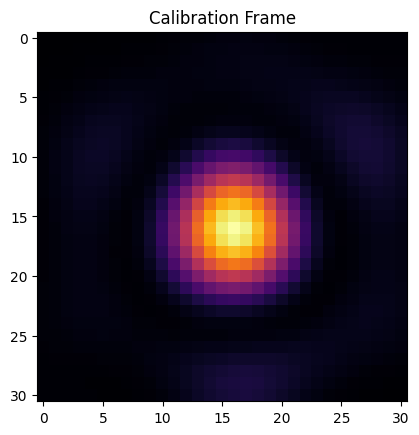

In [5]:
# load in the science frames for imaging the planet
with fits.open("Project_Materials_2009/center_im.fits") as hdulist:
    img_cube = hdulist[0].data # Series of images of the star system taken in time
    exptime = hdulist[0].header['ITIME'] * hdulist[0].header['COADDS']

# the location of the star behind the coronagraph based on the documentaion
star_centx = (img_cube.shape[2]-1)/2
star_centy = (img_cube.shape[1]-1)/2

# load in the calibration frame to calibrate the brightness of any sources with respect to the star
with fits.open("Project_Materials_2009/median_unsat.fits") as hdulist:
    calib_frame = hdulist[0].data # image of the unsaturated star for photometric calibration
    # crop it down because we don't need it so big
    calib_orig_cent = ((calib_frame.shape[0] - 1) // 2, (calib_frame.shape[1] - 1) // 2)
    stamprad = 15
    calib_frame = calib_frame[calib_orig_cent[0]-stamprad:calib_orig_cent[0]+stamprad+1, calib_orig_cent[1]-stamprad:calib_orig_cent[1]+stamprad+1]
    calib_exptime = hdulist[0].header['ITIME'] * hdulist[0].header['COADDS']

# the location of the star in the calibration frame
calib_centx = (calib_frame.shape[1]-1)/2
calib_centy = (calib_frame.shape[0]-1)/2

# the parallactic angles corresponding to each frame for angular differential imaging
with fits.open("Project_Materials_2009/rotnorth.fits") as hdulist:
    rot_angles = hdulist[0].data # negative signs are tricky

plt.figure()
plt.imshow(img_cube[0], cmap="inferno")
plt.xlim([star_centx-150, star_centx+150])
plt.ylim([star_centy-150, star_centy+150])
plt.title("Science Frame")

plt.figure()
plt.imshow(calib_frame, cmap="inferno")
plt.title("Calibration Frame")


In [6]:
centers = np.array([[star_centx, star_centy] for _ in range(img_cube.shape[0])])

dataset = Instrument.GenericData(img_cube, centers, parangs=rot_angles)
dataset.IWA = 25
dataset.OWA = 250

In [7]:
pyklip.parallelized.klip_dataset(dataset, outputdir="./", fileprefix="epoch1", annuli=11,
                                 subsections=1, numbasis=[1,3,5,10,20,30], maxnumbasis=100, mode="ADI",
                                 movement=1)

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 11
90.91% done (9/11 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /home/visage/Documents/github/PSF_Substraction
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 69, 1, 1024, 1024)


/tmp/ipykernel_6059/3919906576.py:1: RuntimeWarning: Mean of empty slice
  output_img = np.nanmean(dataset.output[-1,:,0], axis=0) # combine images in time


Text(0.5, 1.0, 'Residual Map')

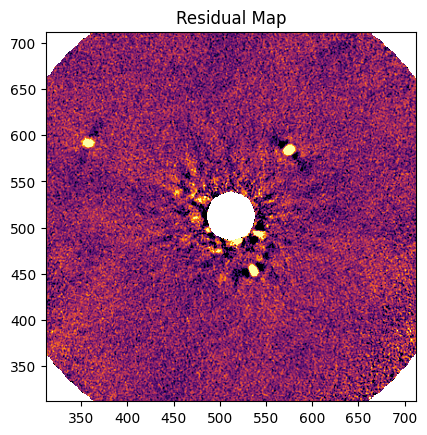

In [8]:
output_img = np.nanmean(dataset.output[-1,:,0], axis=0) # combine images in time

plt.figure()
plt.imshow(output_img, cmap="inferno", vmin=np.nanpercentile(output_img, 1), vmax=np.nanpercentile(output_img, 99.7))
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])
plt.title("Residual Map")

# Calculate all the values needed for magnitude and mass calculations

In [9]:
def process_star(output_img, dataset, guess_x, guess_y, guess_flux):
    try:
        raw_peakflux, fwhm, planet_x, planet_y = pyklip.fakes.gaussfit2d(output_img, guess_x, guess_y, guesspeak=guess_flux)
        print(f"Raw Peak Flux: {raw_peakflux}, FWHM: {fwhm}, Planet X: {planet_x}, Planet Y: {planet_y}")

        star_y, star_x = dataset.output_centers[0]
        planet_sep_pixels = np.sqrt((planet_x - star_x)**2 + (planet_y - star_y)**2)
        planet_PA = np.degrees(np.arctan2(-(planet_x - star_x), planet_y - star_y)) % 360

        platescale = 9.952  # mas/pixel
        planet_sep_mas = planet_sep_pixels * platescale

        print("Planet separation: {0:.2f} mas. Planet PA: {1:.2f} deg".format(planet_sep_mas, planet_PA))
        return {'raw_peak_flux': raw_peakflux, 'fwhm': fwhm, 
                'planet_sep_pixels': planet_sep_pixels,  # Added
                'planet_sep_mas': planet_sep_mas, 'planet_PA': planet_PA,  # Added
                'planet_x': planet_x, 'planet_y': planet_y}
    
    except Exception as e:
        print(f"Error processing star: {e}")

# Process inner and outer planets
inner_planet = process_star(output_img, dataset, guess_x=575, guess_y=583, guess_flux=900)
outer_planet = process_star(output_img, dataset, guess_x=359, guess_y=592, guess_flux=600)

# Extract separate variables for inner planet
inner_raw_peak_flux = inner_planet['raw_peak_flux']
inner_fwhm = inner_planet['fwhm']
inner_planet_x = inner_planet['planet_x']
inner_planet_y = inner_planet['planet_y']
inner_planet_sep_pixels = inner_planet['planet_sep_pixels'] 
inner_planet_PA = inner_planet['planet_PA']  

# Extract separate variables for outer planet
outer_raw_peak_flux = outer_planet['raw_peak_flux']
outer_fwhm = outer_planet['fwhm']
outer_planet_x = outer_planet['planet_x']
outer_planet_y = outer_planet['planet_y']
outer_planet_sep_pixels = outer_planet['planet_sep_pixels']  
outer_planet_PA = outer_planet['planet_PA']  

Raw Peak Flux: 847.8306029622424, FWHM: 7.9533889515748655, Planet X: 574.7705298969463, Planet Y: 583.2608067163567
Planet separation: 945.09 mas. Planet PA: 318.62 deg
Raw Peak Flux: 480.5036319368982, FWHM: 8.103635626376516, Planet X: 357.76709041758176, Planet Y: 590.881397073473
Planet separation: 1724.03 mas. Planet PA: 62.91 deg


/home/visage/.local/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Inner Planet SNR: 8.60396111321479
Outer Planet SNR: 10.059476908058336


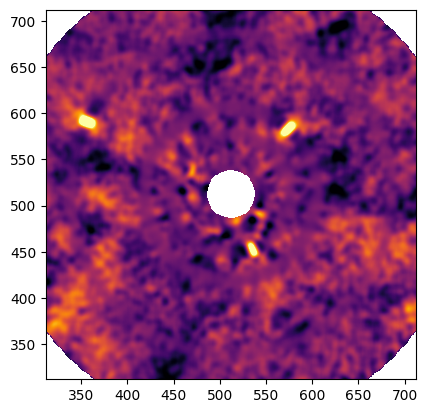

In [10]:
# Use the unocculted image of the star to create a template PSF
calib_centy_int = int(np.round(calib_centy))
calib_centx_int = int(np.round(calib_centx))
template = calib_frame[calib_centy_int-10:calib_centy_int+11, calib_centx_int-10:calib_centx_int+11]

# Perform a cross-correlation of the image with the planet template to get a cross-correlation map
cc_map = pyklip.kpp.metrics.crossCorr.calculate_cc(output_img, template, nans2zero=True)

# Display the cross-correlation map
plt.imshow(cc_map, cmap="inferno", vmin=np.nanpercentile(cc_map, 0.5), vmax=np.nanpercentile(cc_map, 99.9))
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])

# Calculate the SNR map
SNR_map = pyklip.kpp.stat.statPerPix_utils.get_image_stat_map(cc_map,
                                           centroid=dataset.output_centers[0],
                                           r_step=2,
                                           Dr=2,
                                           type="SNR")

# Display the SNR map
plt.imshow(SNR_map, cmap="inferno", vmin=-2.5, vmax=5)
plt.xlim([dataset.output_centers[0,0]-200, dataset.output_centers[0,0]+200])
plt.ylim([dataset.output_centers[0,1]-200, dataset.output_centers[0,1]+200])

# Read off the SNR for both planets using their centroid locations
SNR_map[np.isnan(SNR_map)] = 0  # Mask NaNs for this to work

# Get SNR for inner planet
inner_planet_snr = scipy.ndimage.map_coordinates(SNR_map, [[inner_planet['planet_y']], [inner_planet['planet_x']]])
print(f"Inner Planet SNR: {inner_planet_snr[0]}")
# Get SNR for outer planet
outer_planet_snr = scipy.ndimage.map_coordinates(SNR_map, [[outer_planet['planet_y']], [outer_planet['planet_x']]])
print(f"Outer Planet SNR: {outer_planet_snr[0]}")

In [11]:
# Measure the flux of the star without the coronagraph but taken with a different exposure time
peakflux_star, _, _, _ = pyklip.fakes.gaussfit2d(calib_frame, calib_centx, calib_centy, guesspeak=10000)

# Scale the star to the approximate brightness of the inner planet (in detector units)
inner_planet_template = calib_frame * (inner_raw_peak_flux / peakflux_star)

# Scale the star to the approximate brightness of the outer planet (in detector units)
outer_planet_template = calib_frame * (outer_raw_peak_flux / peakflux_star)

# Create a new dataset for synthetic planet injection
fakes_dataset = Instrument.GenericData(np.copy(img_cube), centers, parangs=rot_angles)
fakes_dataset.IWA = 25
fakes_dataset.OWA = 250

# Inject the synthetic inner planet at 90 degrees away from the real planet, but at the same separation
inner_planet_template_cube = np.array([inner_planet_template for frame in fakes_dataset.input])  # a PSF template for each frame
pyklip.fakes.inject_planet(fakes_dataset.input, fakes_dataset.centers, inner_planet_template_cube, dataset.wcs, inner_planet_sep_pixels, inner_planet_PA + 90)

# Inject the synthetic outer planet at -90 degrees away from the real planet, but at the same separation
outer_planet_template_cube = np.array([outer_planet_template for frame in fakes_dataset.input])  # a PSF template for each frame
pyklip.fakes.inject_planet(fakes_dataset.input, fakes_dataset.centers, outer_planet_template_cube, dataset.wcs, outer_planet_sep_pixels, outer_planet_PA - 90)



!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!THE INJECTION MIGHT BE WRONG! BUT I AM A BIT TIRED!

Begin align and scale images for each wavelength
Wavelength 1.0 with index 0 has finished align and scale. Queuing for KLIP
Total number of tasks for KLIP processing is 11
90.91% done (9/11 completed)
Closing threadpool
Derotating Images...
Writing Images to directory /home/visage/Documents/github/PSF_Substraction
wavelength collapsing reduced data of shape (b, N, wv, y, x):(6, 69, 1, 1024, 1024)
Raw Peak Flux: 830.3781203762633, FWHM: 7.926471444598781, Planet X: 574.7677423440134, Planet Y: 583.2691853054453
Planet separation: 945.13 mas. Planet PA: 318.63 deg
Raw Peak Flux: 479.52279340868887, FWHM: 8.097080835086327, Planet X: 357.7678005305986, Planet Y: 590.8811026046487
Planet separation: 1724.02 mas. Planet PA: 62.91 deg


/tmp/ipykernel_6059/2423326056.py:15: RuntimeWarning: Mean of empty slice
  fakes_output_img = np.nanmean(fakes_dataset.output[-1, :, 0], axis=0)


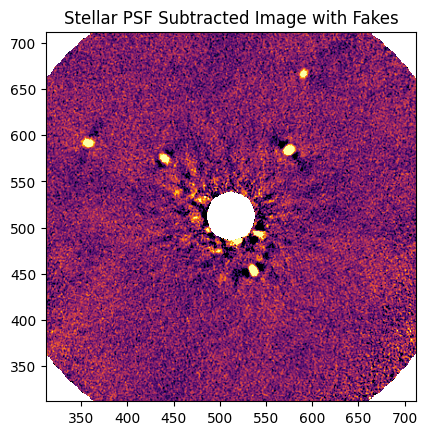

In [12]:
# Run the KLIP algorithm on the dataset
pyklip.parallelized.klip_dataset(
    fakes_dataset, 
    outputdir="./", 
    fileprefix="fakepl_epoch1", 
    annuli=11,
    subsections=1, 
    numbasis=[1, 3, 5, 10, 20, 30], 
    maxnumbasis=100, 
    mode="ADI",
    movement=1
)

# Combine images in time
fakes_output_img = np.nanmean(fakes_dataset.output[-1, :, 0], axis=0) 

# Display the combined image
plt.figure()
plt.imshow(fakes_output_img, cmap="inferno", vmin=np.nanpercentile(fakes_output_img, 1), vmax=np.nanpercentile(fakes_output_img, 99.7))
plt.xlim([fakes_dataset.output_centers[0, 0] - 200, fakes_dataset.output_centers[0, 0] + 200])
plt.ylim([fakes_dataset.output_centers[0, 1] - 200, fakes_dataset.output_centers[0, 1] + 200])
plt.title("Stellar PSF Subtracted Image with Fakes")

# Process inner and outer planets using the output image
inner_planet = process_star(fakes_output_img, fakes_dataset, guess_x=575, guess_y=583, guess_flux=900)
outer_planet = process_star(fakes_output_img, fakes_dataset, guess_x=359, guess_y=592, guess_flux=600)

# Extract variables for inner planet
inner_raw_peak_flux = inner_planet['raw_peak_flux']
inner_fwhm = inner_planet['fwhm']
inner_planet_x = inner_planet['planet_x']
inner_planet_y = inner_planet['planet_y']
inner_planet_sep_pixels = inner_planet['planet_sep_pixels']
inner_planet_PA = inner_planet['planet_PA']

# Extract variables for outer planet
outer_raw_peak_flux = outer_planet['raw_peak_flux']
outer_fwhm = outer_planet['fwhm']
outer_planet_x = outer_planet['planet_x']
outer_planet_y = outer_planet['planet_y']
outer_planet_sep_pixels = outer_planet['planet_sep_pixels']
outer_planet_PA = outer_planet['planet_PA']


In [13]:
# Define the input PAs for the fake planets
fake_input_pas = [inner_planet_PA + 90, outer_planet_PA - 90]  # Adjusted to use the measured PAs
fake_measured_peakfluxes = []
fake_measured_seps = []
fake_measured_PAs = []
platescale = 9.952  # mas/pixel

for this_fake_pa in fake_input_pas:
    # Figure out guess location for Gaussian fit using the known location
    # Convert sep/PA to x/y
    star_y, star_x = fakes_dataset.output_centers[0]
    
    # Using inner planet's separation for the first PA and outer for the second
    planet_sep_pixels = inner_planet_sep_pixels if this_fake_pa == (inner_planet_PA + 90) else outer_planet_sep_pixels
    
    fake_input_x = -planet_sep_pixels * np.sin(np.radians(this_fake_pa)) + star_x
    fake_input_y = planet_sep_pixels * np.cos(np.radians(this_fake_pa)) + star_y

    # Perform Gaussian fitting
    fake_raw_peakflux, fake_fwhm, fakeplanet_x, fakeplanet_y = pyklip.fakes.gaussfit2d(fakes_output_img, fake_input_x, fake_input_y, guesspeak=900 if this_fake_pa == (inner_planet_PA + 90) else 600)

    # Calculate separation and PA
    fake_sep_pixels = np.sqrt((fakeplanet_x - star_x)**2 + (fakeplanet_y - star_y)**2)
    fake_planet_PA = np.degrees(np.arctan2(-(fakeplanet_x - star_x), fakeplanet_y - star_y)) % 360

    # Convert separation to mas
    fake_planet_sep = fake_sep_pixels * platescale

    # Append results to lists
    fake_measured_seps.append(fake_planet_sep)
    fake_measured_PAs.append(fake_planet_PA)
    fake_measured_peakfluxes.append(fake_raw_peakflux)


In [14]:
# Calculate algo_throughput for inner and outer planets
algo_throughput_inner = np.mean(fake_measured_peakfluxes) / inner_raw_peak_flux
algo_throughput_outer = np.mean(fake_measured_peakfluxes) / outer_raw_peak_flux  

# Calculate flux ratios for inner and outer planets
flux_ratio_inner = (inner_raw_peak_flux / exptime) / algo_throughput_inner / (peakflux_star / calib_exptime)
flux_ratio_outer = (outer_raw_peak_flux / exptime) / algo_throughput_outer / (peakflux_star / calib_exptime)

# Print results
print("Inner Planet - algo throughput:", algo_throughput_inner)
print("Inner Planet - flux ratio:", flux_ratio_inner)

print("Outer Planet - algo throughput:", algo_throughput_outer)
print("Outer Planet - flux ratio:", flux_ratio_outer)


Inner Planet - algo throughput: 0.4649667302187714
Inner Planet - flux ratio: 0.000199173200514401
Outer Planet - algo throughput: 0.805171734865783
Outer Planet - flux ratio: 6.641980837840054e-05


# Mass Calculation

In [38]:
#our model, same used on the jupyter

database = Database()
database.add_isochrones(model='ames')


------------------
Add isochrone grid
------------------

Evolutionary model: ames
File name: None
Database tag: None

Adding isochrones: ames-cond... [DONE]
Database tag: ames-cond

Adding isochrones: ames-dusty... [DONE]
Database tag: ames-dusty


In [39]:
star_lmag = 5.22
star_abs_lmag = star_lmag - 5 * np.log10(40.879/10)
planet_abs_lmag = star_abs_lmag - 2.5 * np.log10(planet_fluxratio)
print(planet_abs_lmag)

12.16249868322604


In [41]:
# Calculate star's absolute luminosity magnitude
star_abs_lmag = star_lmag - 5 * np.log10(40.879 / 10)

# Calculate planet's absolute luminosity magnitude for inner and outer planets
planet_abs_lmag_inner = star_abs_lmag - 2.5 * np.log10(flux_ratio_inner)
planet_abs_lmag_outer = star_abs_lmag - 2.5 * np.log10(flux_ratio_outer)


print("Inner Planet - absolute luminosity magnitude:", planet_abs_lmag_inner)
print("Outer Planet - absolute luminosity magnitude:", planet_abs_lmag_outer)


Inner Planet - absolute luminosity magnitude: 11.414421427973014
Outer Planet - absolute luminosity magnitude: 12.60675463742195


In [47]:
#Getting the value of isobox for 40MYR

iso_box = read_iso.get_isochrone(age=40., masses=np.linspace(1., 30., 50), filter_mag="L'")
#iso_box.open_box()

planet_mass_inner = np.interp(planet_abs_lmag_inner, iso_box.magnitude[::-1], iso_box.mass[::-1])
planet_mass_outer = np.interp(planet_abs_lmag_outer, iso_box.magnitude[::-1], iso_box.mass[::-1])


print("Inner Planet - mass (Jupiter masses):", planet_mass_inner)
print("Outer Planet - mass (Jupiter masses):", planet_mass_outer)

Inner Planet - mass (Jupiter masses): 10.060828367312055
Outer Planet - mass (Jupiter masses): 6.3443225676083514


In [48]:
#Getting the value of isobox for 80MYR

iso_box = read_iso.get_isochrone(age=80., masses=np.linspace(1., 30., 50), filter_mag="L'")
#iso_box.open_box()

planet_mass_inner = np.interp(planet_abs_lmag_inner, iso_box.magnitude[::-1], iso_box.mass[::-1])
planet_mass_outer = np.interp(planet_abs_lmag_outer, iso_box.magnitude[::-1], iso_box.mass[::-1])


print("Inner Planet - mass (Jupiter masses):", planet_mass_inner)
print("Outer Planet - mass (Jupiter masses):", planet_mass_outer)

Inner Planet - mass (Jupiter masses): 11.711344133883266
Outer Planet - mass (Jupiter masses): 9.27358317827335


In [50]:
#Getting the value of isobox for 20MYR

iso_box = read_iso.get_isochrone(age=20., masses=np.linspace(1., 30., 50), filter_mag="L'")
#iso_box.open_box()

planet_mass_inner = np.interp(planet_abs_lmag_inner, iso_box.magnitude[::-1], iso_box.mass[::-1])
planet_mass_outer = np.interp(planet_abs_lmag_outer, iso_box.magnitude[::-1], iso_box.mass[::-1])


print("Inner Planet - mass (Jupiter masses):", planet_mass_inner)
print("Outer Planet - mass (Jupiter masses):", planet_mass_outer)

Inner Planet - mass (Jupiter masses): 6.947965823321629
Outer Planet - mass (Jupiter masses): 4.272917489285939
